# Music Recommendation System

In [1]:
# Load Python libraries
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

### Importing Datasets

In [2]:
df = pd.read_csv('/content/train.csv')

In [3]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0


In [4]:
df.shape

(54657, 6)

In [5]:
df = df.sample(frac=0.1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5466 entries, 51589 to 41380
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msno                5466 non-null   object 
 1   song_id             5466 non-null   object 
 2   source_system_tab   5456 non-null   object 
 3   source_screen_name  5244 non-null   object 
 4   source_type         5463 non-null   object 
 5   target              5466 non-null   float64
dtypes: float64(1), object(5)
memory usage: 298.9+ KB


In [7]:
songs = pd.read_csv('/content/songs.csv')

In [8]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73896 entries, 0 to 73895
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   song_id      73896 non-null  object 
 1   song_length  73896 non-null  int64  
 2   genre_ids    72534 non-null  object 
 3   artist_name  73896 non-null  object 
 4   composer     42980 non-null  object 
 5   lyricist     20342 non-null  object 
 6   language     73895 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 3.9+ MB


In [9]:
df = pd.merge(df, songs, on='song_id', how='left')
del songs

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5466 entries, 0 to 5465
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msno                5466 non-null   object 
 1   song_id             5466 non-null   object 
 2   source_system_tab   5456 non-null   object 
 3   source_screen_name  5244 non-null   object 
 4   source_type         5463 non-null   object 
 5   target              5466 non-null   float64
 6   song_length         1498 non-null   float64
 7   genre_ids           1479 non-null   object 
 8   artist_name         1498 non-null   object 
 9   composer            1180 non-null   object 
 10  lyricist            920 non-null    object 
 11  language            1498 non-null   float64
dtypes: float64(3), object(9)
memory usage: 555.1+ KB


In [11]:
members = pd.read_csv('/content/members.csv')

In [12]:
df = pd.merge(df, members, on='msno', how='left')
del members

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5466 entries, 0 to 5465
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    5466 non-null   object 
 1   song_id                 5466 non-null   object 
 2   source_system_tab       5456 non-null   object 
 3   source_screen_name      5244 non-null   object 
 4   source_type             5463 non-null   object 
 5   target                  5466 non-null   float64
 6   song_length             1498 non-null   float64
 7   genre_ids               1479 non-null   object 
 8   artist_name             1498 non-null   object 
 9   composer                1180 non-null   object 
 10  lyricist                920 non-null    object 
 11  language                1498 non-null   float64
 12  city                    5466 non-null   int64  
 13  bd                      5466 non-null   int64  
 14  gender                  3362 non-null   

##### Replace NA

In [14]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5466 entries, 0 to 5465
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    5466 non-null   object 
 1   song_id                 5466 non-null   object 
 2   source_system_tab       5466 non-null   object 
 3   source_screen_name      5466 non-null   object 
 4   source_type             5466 non-null   object 
 5   target                  5466 non-null   float64
 6   song_length             5466 non-null   float64
 7   genre_ids               5466 non-null   object 
 8   artist_name             5466 non-null   object 
 9   composer                5466 non-null   object 
 10  lyricist                5466 non-null   object 
 11  language                5466 non-null   float64
 12  city                    5466 non-null   int64  
 13  bd                      5466 non-null   int64  
 14  gender                  5466 non-null   

##### Create Dates

In [16]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [17]:
#Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [18]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

In [19]:
df.corr()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
msno,1.000000,-0.011744,-0.007057,0.005528,-0.025442,-0.008539,0.016159,-0.009716,0.013774,0.023858,...,-0.013604,0.021340,-0.024426,-0.011551,-0.034653,0.022321,-0.004884,-0.013155,0.004801,0.012901
song_id,-0.011744,1.000000,0.007691,-0.006459,0.004273,-0.017220,0.034185,-0.019527,0.014526,-0.019333,...,-0.002493,-0.014185,0.000422,0.001374,-0.000211,-0.002043,0.021433,0.004227,-0.006155,0.008322
source_system_tab,-0.007057,0.007691,1.000000,-0.032066,-0.206214,0.099679,0.008854,-0.002849,-0.000999,0.005080,...,-0.007581,0.019936,-0.025072,0.059589,-0.011040,-0.054755,0.028283,0.042075,0.009171,0.045959
source_screen_name,0.005528,-0.006459,-0.032066,1.000000,0.325509,-0.137878,0.017293,-0.011999,0.033677,0.012883,...,0.011713,0.002045,0.016131,-0.052625,0.014307,0.001298,0.004994,-0.041146,-0.007362,0.022740
source_type,-0.025442,0.004273,-0.206214,0.325509,1.000000,-0.161470,0.026973,-0.024978,0.027323,-0.011761,...,-0.013921,0.011389,-0.024798,-0.028066,-0.033527,0.006969,-0.025737,-0.035410,0.022142,-0.032341
target,-0.008539,-0.017220,0.099679,-0.137878,-0.161470,1.000000,0.013615,-0.014728,-0.001936,0.003530,...,-0.003590,-0.004645,0.010043,0.079767,0.009232,0.009051,0.017096,0.050577,0.021682,0.016497
song_length,0.016159,0.034185,0.008854,0.017293,0.026973,0.013615,1.000000,-0.897671,0.108202,-0.043952,...,-0.005847,0.024693,0.003881,0.018109,0.002101,0.004412,-0.006700,0.015346,-0.003374,0.004935
genre_ids,-0.009716,-0.019527,-0.002849,-0.011999,-0.024978,-0.014728,-0.897671,1.000000,0.011031,0.145166,...,0.003297,-0.024291,0.003765,-0.015685,0.004204,-0.003141,0.013886,-0.020184,0.015091,-0.003383
artist_name,0.013774,0.014526,-0.000999,0.033677,0.027323,-0.001936,0.108202,0.011031,1.000000,0.358209,...,0.002919,0.007082,0.002783,0.027319,0.003941,-0.003315,-0.016767,0.016038,0.011490,-0.014695
composer,0.023858,-0.019333,0.005080,0.012883,-0.011761,0.003530,-0.043952,0.145166,0.358209,1.000000,...,-0.002399,-0.007825,-0.001164,-0.014335,-0.005525,0.024249,0.004699,-0.015304,0.005477,0.013467


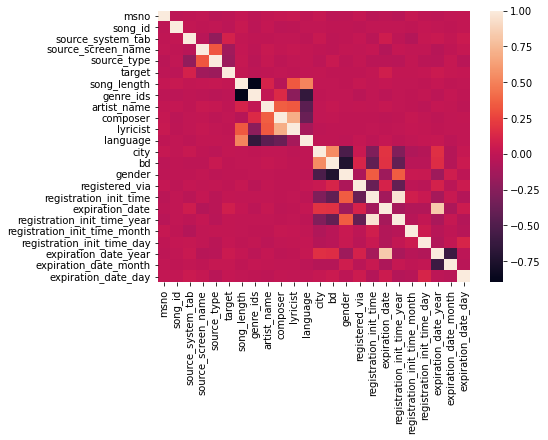

In [20]:
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

### RandomForest

In [21]:
# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [22]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

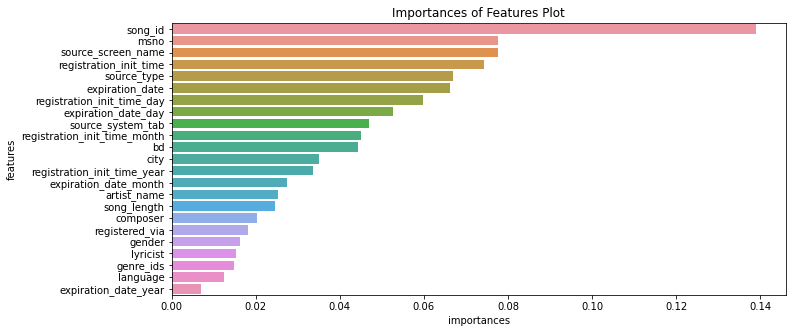

In [23]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [24]:
model.feature_importances_

array([0.07769906, 0.13906098, 0.04695254, 0.07757925, 0.0669318 ,
       0.02451252, 0.01482518, 0.02524742, 0.02018397, 0.01534011,
       0.01239847, 0.03507286, 0.04431582, 0.01620409, 0.01822466,
       0.07426443, 0.06615163, 0.0335009 , 0.04493688, 0.0596839 ,
       0.00689866, 0.02738087, 0.05263399])

In [25]:
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [26]:
list(df.columns)

['msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'target',
 'bd',
 'registration_init_time',
 'expiration_date',
 'registration_init_time_month',
 'registration_init_time_day',
 'expiration_date_day']

In [27]:
target = df.pop('target')

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(max_depth=15, min_child_weight=5, n_estimators=250)

In [30]:
predict_labels = model.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

         0.0       0.56      0.40      0.47       394
         1.0       0.83      0.90      0.86      1246

    accuracy                           0.78      1640
   macro avg       0.69      0.65      0.66      1640
weighted avg       0.76      0.78      0.77      1640

